In [3]:
#Data Analysis for second wind only experiment Conducted on Nov 18 2020
from asist.utility import power_spectrum
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import detrend
from scipy.stats import beta
from sustain_drag_2020.irgason import read_irgason_from_toa5, rotate
from sustain_drag_2020.udm import read_udm_from_toa5
from sustain_drag_2020.fetch import fetch
from sustain_drag_2020.dispersion import w2k
import xarray as xr
import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib
font = {'size': 16}
matplotlib.rc('font', **font)

In [4]:
fetch_nov2020 = {
    'irgason': 9.55,
    'pitot': 9.85,
    'static_pressure': np.array([1.68, 3.51, 5.34, 7.17, 9.00, 10.83, 12.66, 14.49, 16.32]),
    'udm': np.array([3.40, 6.25, 8.85, 11.31, 13.96]),
    'wave_wire': np.array([1.53, 6.14, 9.30, 10.80])
}

In [5]:
os.chdir('/Users/peisen/Downloads/20201118/NC/')
ds = xr.open_dataset('sustain_drag_20201118_JONSWAP.nc')

In [6]:
ds

<xarray.Dataset>
Dimensions:  (fetch_p: 9, fetch_u: 5, fetch_w: 4, time: 132001, time_p: 66000)
Coordinates:
  * time     (time) float64 0.0 0.05 0.1 0.15 ... 6.6e+03 6.6e+03 6.6e+03
  * time_p   (time_p) float64 0.1 0.2 0.3 0.4 ... 6.6e+03 6.6e+03 6.6e+03
  * fetch_w  (fetch_w) float64 1.53 9.3 10.8 14.0
  * fetch_u  (fetch_u) float64 3.4 6.25 8.85 11.31 13.96
  * fetch_p  (fetch_p) float64 1.68 3.51 5.34 7.17 9.0 10.83 12.66 14.49 16.32
Data variables:
    fan      (time) float64 ...
    fan_p    (time_p) float64 ...
    u        (time) float64 ...
    v        (time) float64 ...
    w        (time) float64 ...
    T        (time) float64 ...
    eta_w    (fetch_w, time) float64 ...
    eta_u    (fetch_u, time) float64 ...
    p        (fetch_p, time_p) float64 ...
Attributes:
    experiment_name:      JONSWAP_fresh-water_20201118
    experiment_time:      2020-11-18_17:53:00
    water_type:           fresh
    initial_water_depth:  0.8
    institution:          University of Miami
    facility:             SUSTAIN Laboratory
    tank:                 SUSTAIN
    contact:              Milan Curcic <mcurcic@miami.edu>

In [7]:
fan = range(0, 55, 5)
start_time = datetime.strptime(ds.experiment_time, '%Y-%m-%d_%H:%M:%S')
num_runs = len(fan)
run_seconds = 600
offset = 60

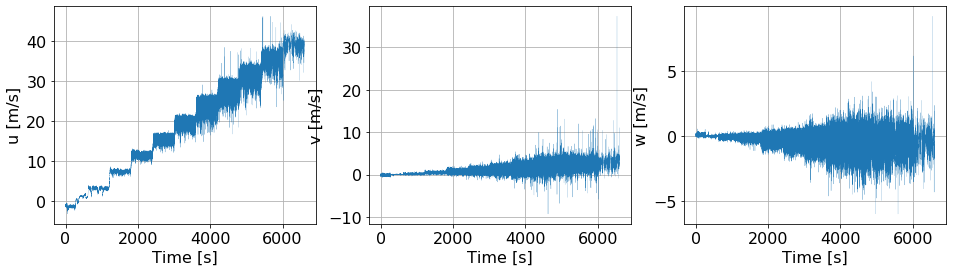

In [8]:
plt.figure(figsize=(16, 4))
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1))
ax3 = plt.subplot2grid((1, 3), (0, 2))
ax1.plot(ds.time, ds.u, lw=0.2)
ax2.plot(ds.time, ds.v, lw=0.2)
ax3.plot(ds.time, ds.w, lw=0.2)
ax1.set_ylabel('u [m/s]')
ax2.set_ylabel('v [m/s]')
ax3.set_ylabel('w [m/s]')
for ax in [ax1, ax2, ax3]:
    ax.grid()
    ax.set_xlabel('Time [s]')

In [9]:
def eddy_covariance_flux(ds, t0, t1):
    """Eddy covariance flux from IRGASON, for a time subset between t0 and t1."""
    time = np.array(ds.time)
    mask = (time >= t0) & (time <= t1)
    u, v, w = ds.u[mask][:], ds.v[mask][:], ds.w[mask][:]
    u = np.sqrt(u**2 + v**2) # horizontal velocity
    angle = np.arctan2(np.nanmean(w), np.nanmean(u))
    u, w = rotate(u, w, angle)
    U, W = np.nanmean(u), np.nanmean(w) # time mean
    up, wp = u - U, w - W # deviations from the mean
    uw = np.nanmean(up * wp) # stress
    good = ~np.isnan(u) & ~np.isnan(w)
    perc_good = (u[good].size / u.size) * 100 # percentage of data that is not bad
    return U, uw, perc_good

In [10]:
U = np.zeros(num_runs)
uw = np.zeros(num_runs)
perc_good = np.zeros(num_runs)
for n in range(num_runs):
    t0 = n * run_seconds + offset
    t1 = t0 + run_seconds - offset
    U[n], uw[n], perc_good[n] = eddy_covariance_flux(ds, t0, t1)

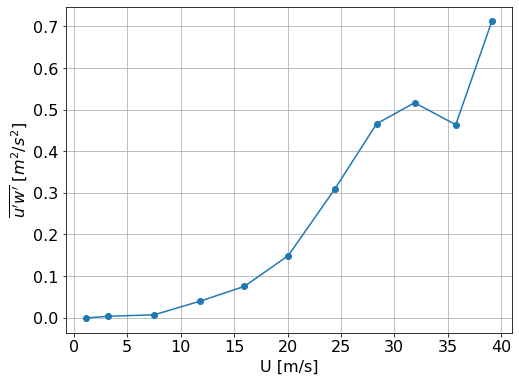

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(U, uw, marker='o')
plt.xlabel('U [m/s]')
plt.ylabel(r"$\overline{u'w'}$ [$m^2/s^2$]")
plt.grid()

Text(0, 0.5, 'Pressure [Pa]')

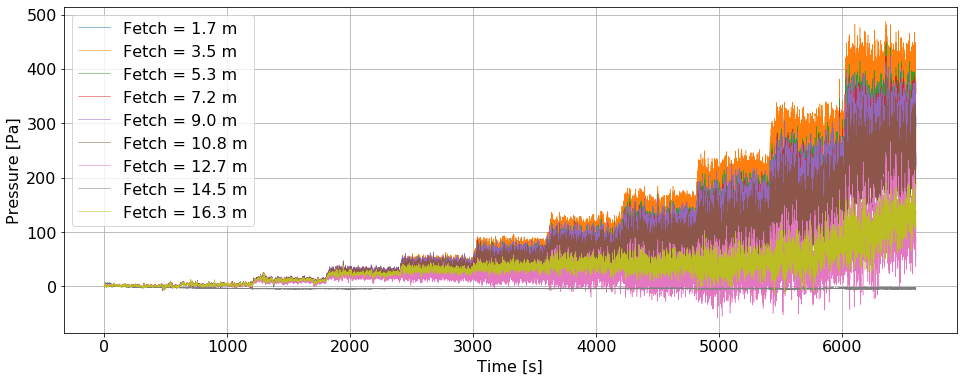

In [12]:
plt.figure(figsize=(16, 6))
for n, x in enumerate(ds.fetch_p):
    plt.plot(ds.time_p, ds.p[n,:], lw=0.5, label='Fetch = %.1f m' % x)
plt.legend()
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('Pressure [Pa]')

In [13]:
ds

<xarray.Dataset>
Dimensions:  (fetch_p: 9, fetch_u: 5, fetch_w: 4, time: 132001, time_p: 66000)
Coordinates:
  * time     (time) float64 0.0 0.05 0.1 0.15 ... 6.6e+03 6.6e+03 6.6e+03
  * time_p   (time_p) float64 0.1 0.2 0.3 0.4 ... 6.6e+03 6.6e+03 6.6e+03
  * fetch_w  (fetch_w) float64 1.53 9.3 10.8 14.0
  * fetch_u  (fetch_u) float64 3.4 6.25 8.85 11.31 13.96
  * fetch_p  (fetch_p) float64 1.68 3.51 5.34 7.17 9.0 10.83 12.66 14.49 16.32
Data variables:
    fan      (time) float64 ...
    fan_p    (time_p) float64 0.0 0.0 0.0 0.0 0.0 ... 50.0 50.0 50.0 50.0 55.0
    u        (time) float64 -1.251 -1.169 -1.178 -1.147 ... 38.89 39.86 nan nan
    v        (time) float64 -0.2975 -0.2125 -0.2112 -0.1559 ... 3.402 nan nan
    w        (time) float64 0.04391 0.04072 0.1179 0.09292 ... -0.5775 nan nan
    T        (time) float64 ...
    eta_w    (fetch_w, time) float64 ...
    eta_u    (fetch_u, time) float64 ...
    p        (fetch_p, time_p) float64 ...
Attributes:
    experiment_name:      JONSWAP_fresh-water_20201118
    experiment_time:      2020-11-18_17:53:00
    water_type:           fresh
    initial_water_depth:  0.8
    institution:          University of Miami
    facility:             SUSTAIN Laboratory
    tank:                 SUSTAIN
    contact:              Milan Curcic <mcurcic@miami.edu>

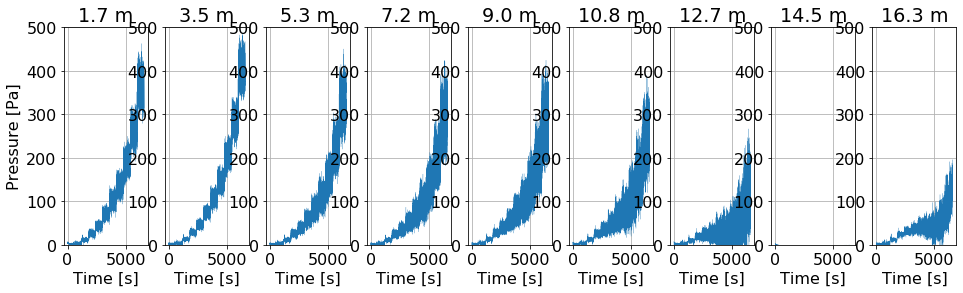

In [14]:
fig = plt.figure(figsize=(16, 4))
for n in range(9):
    ax = plt.subplot2grid((1, 9), (0, n))
    ax.plot(ds.time_p, ds.p[n,:], lw=0.2)
    plt.title('%.1f m' % ds.fetch_p[n])
    plt.grid(True)
    plt.ylim(0, 500)
    if n == 0: plt.ylabel('Pressure [Pa]')
    plt.xlabel('Time [s]')

In [15]:
def mean_pressure(p, time, fan, run_seconds, offset):
    pmean = np.zeros((len(fan), p.shape[0]))
    pstd = np.zeros((len(fan), p.shape[0]))
    for n in range(len(fan)):
        t0 = n * run_seconds + offset
        t1 = t0 + run_seconds - offset
        mask = (time >= t0) & (time < t1)
        for i in range(p.shape[0]):
            pp = p[i,mask]
            pmean[n,i] = np.mean(pp)
            pstd[n,i] = np.std(pp)
    return pmean, pstd

In [16]:
pmean, pstd = mean_pressure(np.array(ds.p), np.array(ds.time_p), fan, run_seconds, offset)

In [24]:
# there was an issue with this port and it didn't record; mask it out
pmean[:,7] = np.nan
pstd[:,7] = np.nan

Text(0, 0.5, 'Mean pressure [Pa]')

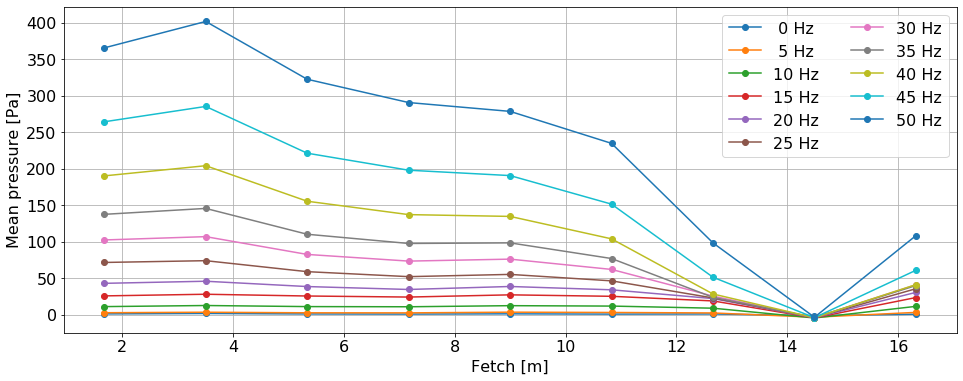

In [17]:
plt.figure(figsize=(16, 6))
for n, f in enumerate(fan):
    plt.plot(ds.fetch_p, pmean[n,:], marker='o', label='%2i Hz' % f)
plt.legend(ncol=2)
plt.grid()
plt.xlabel('Fetch [m]')
plt.ylabel('Mean pressure [Pa]')

Text(0, 0.5, 'Pressure standard deviation [Pa]')

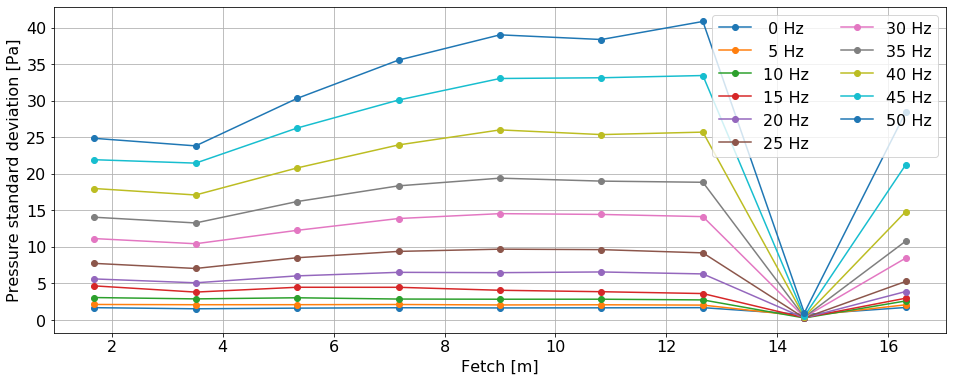

In [18]:
plt.figure(figsize=(16, 6))
for n, f in enumerate(fan):
    plt.plot(ds.fetch_p, pstd[n,:], marker='o', label='%2i Hz' % f)
plt.legend(ncol=2)
plt.grid()
plt.xlabel('Fetch [m]')
plt.ylabel('Pressure standard deviation [Pa]')


Text(0, 0.5, 'Pressure [Pa]')

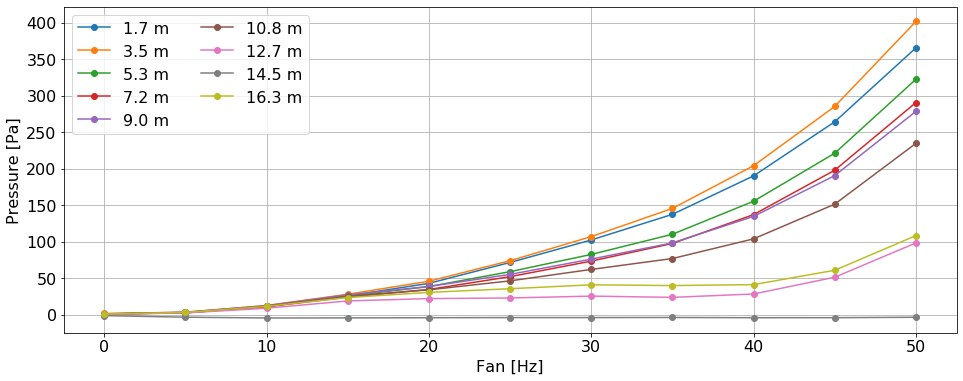

In [19]:
plt.figure(figsize=(16, 6))
for i, x in enumerate(ds.fetch_p):
    plt.plot(fan, pmean[:,i], marker='o', label='%.1f m' % x)
plt.legend(ncol=2)
plt.grid()
plt.xlabel('Fan [Hz]')
plt.ylabel('Pressure [Pa]')

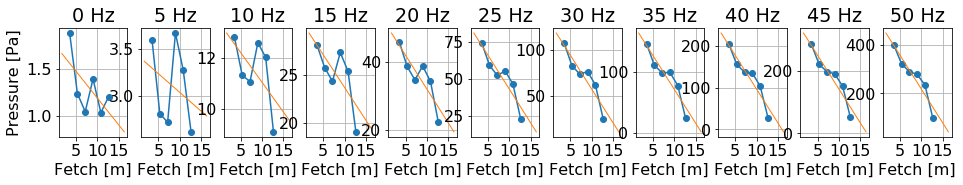

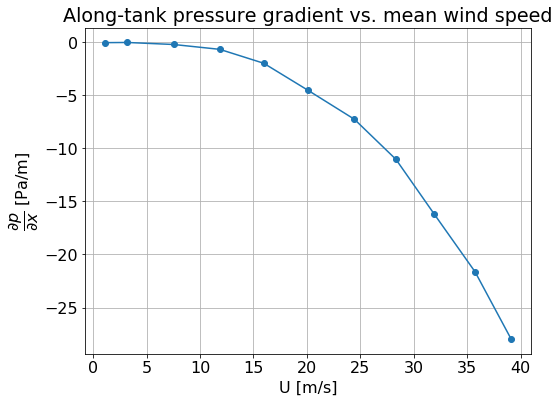

In [20]:
good = [1, 2, 3, 4, 5, 6]

fig = plt.figure(figsize=(16, 2))
dpdx = np.zeros((len(fan)))
for n in range(len(fan)):
    ax = plt.subplot2grid((1, len(fan)), (0, n))
    plt.plot(ds.fetch_p[good], pmean[n,good], marker='o')
    p = np.polyfit(ds.fetch_p[good], pmean[n,good], 1)
    dpdx[n] = p[0]
    x = ds.fetch_p
    plt.plot(x, np.polyval(p, x), lw=1)
    plt.xlabel('Fetch [m]')
    if n == 0: plt.ylabel('Pressure [Pa]')
    plt.title(str(fan[n]) + ' Hz')
    plt.grid()



plt.figure(figsize=(8, 6))
plt.plot(U, dpdx, marker='o')
plt.xlabel('U [m/s]')
plt.ylabel(r'$\dfrac{\partial p}{\partial x}$ [Pa/m]')
plt.title('Along-tank pressure gradient vs. mean wind speed')
plt.grid()

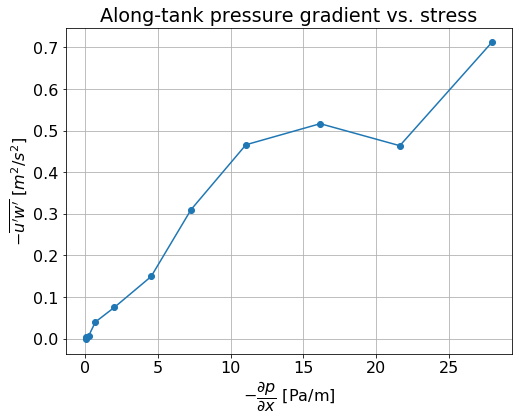

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(-dpdx, uw, marker='o')
plt.xlabel(r'$-\dfrac{\partial p}{\partial x}$ [Pa/m]')
plt.ylabel(r"$-\overline{u'w'}$ [$m^2/s^2$]")
plt.title('Along-tank pressure gradient vs. stress')
plt.grid()

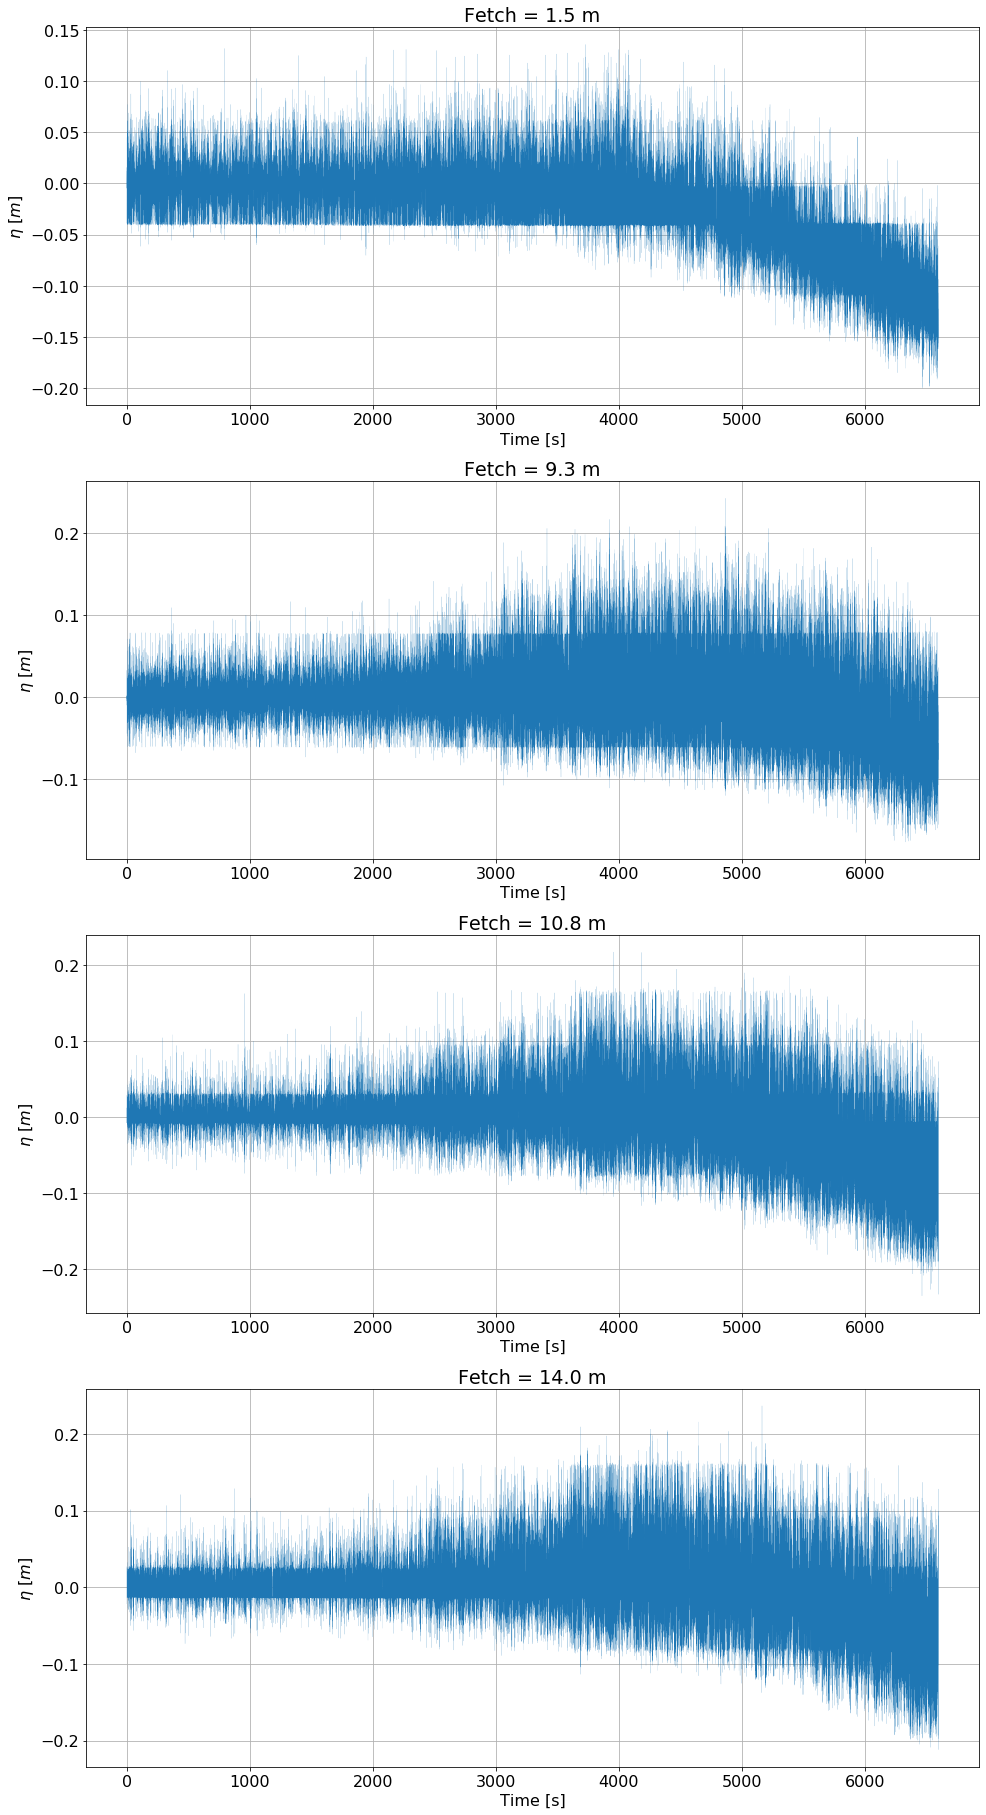

In [21]:
num_wires = ds.fetch_w.shape[0]

fig = plt.figure(figsize=(16, 32))
for i in range(num_wires):
    ax = plt.subplot2grid((num_wires, 1), (i, 0))
    ax.plot(ds.time, ds.eta_w[i], lw=0.1)
    ax.set_title('Fetch = %.1f m' % ds.fetch_w[i])
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('$\eta$ [$m$]')
    ax.grid()

<class 'int'>
<class 'int'>


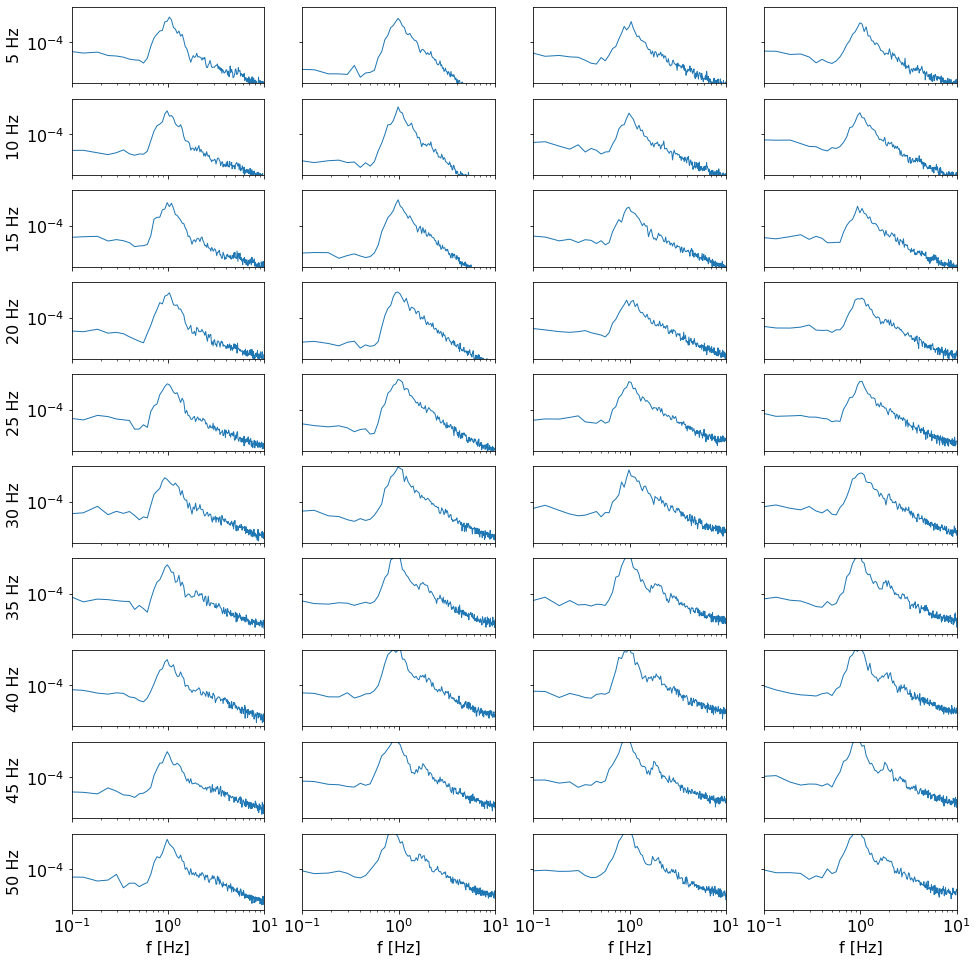

In [22]:
#Wavewire spectrum from Run1 wind only
fan = range(0, 55, 5)
start_time = datetime.strptime(ds.experiment_time, '%Y-%m-%d_%H:%M:%S')
num_runs = len(fan)
run_seconds = 600
offset = 60

fig = plt.figure(figsize=(20, 20))
data_int=int(600/.05);
print(type(i))
print(type(n))
for n in range(1, len(fan)):
    for i in range(4):
        ax = plt.subplot2grid((12, 5), (n - 1, i))
        e = detrend(ds.eta_w[i,(n-1)*data_int+1:n*data_int])
        F, f, df = power_spectrum(e, 1 / 20, binsize=32)
        
        ax.loglog(f, F, lw=1)
        plt.xlim(1e-1, 1e1)
        plt.ylim(5e-7, 1e-2)
        #if n == 1: plt.title('Fetch = ' + str(fetch[i]) + ' m', fontsize=16)
        if n == 10: plt.xlabel('f [Hz]', fontsize=16)
        if n != 10: ax.set_xticklabels([])
        if i == 0: plt.ylabel(str(fan[n]) + ' Hz', fontsize=16)
        if i != 0: ax.set_yticklabels([])



In [23]:
Hs = np.zeros((11, 4))
mss_all= Hs
Tp = np.zeros((11, 4))
for n in range(1, len(fan)):
    for i in range(4):
        e = detrend(ds.eta_w[i,(n-1)*data_int+1:n*data_int])
        F, f, df = power_spectrum(e, 1 / 20)
        
        fmask = (f > 0.5) & (f < 5)
        F, f = F[fmask], f[fmask]
        
        Hs[n-1,i] = 2 * np.sqrt(np.sum(F) * df)
        Tp[n-1,i] = np.sum(F**4) / np.sum(F**4 * f)
        

(0, 0.4)

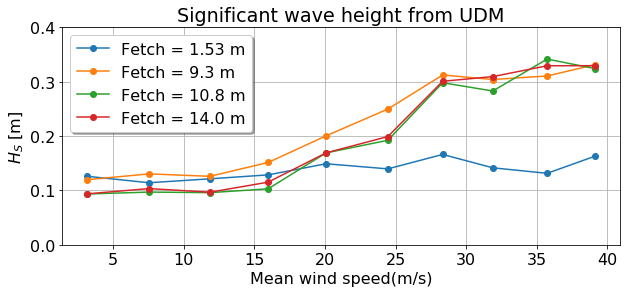

In [24]:
fetch=np.array([1.53, 9.30, 10.80,14])


fig = plt.figure(figsize=(10, 4))
for i in range(4):
    plt.plot(U[1:], Hs[:-1,i], marker='o', label='Fetch = ' + str(fetch[i]) + ' m')
               
plt.legend(loc='upper left', fancybox=True, shadow=True)
plt.grid()
plt.title('Significant wave height from UDM')
plt.xlabel('Mean wind speed(m/s)')
plt.ylabel(r'$H_S$ [m]')
plt.ylim([0, 0.4])

(0.5, 1.5)

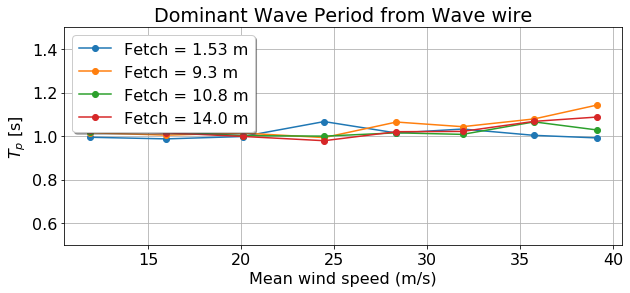

In [80]:
fig = plt.figure(figsize=(10, 4))
for i in range(4):
    plt.plot(U[3:], Tp[2:-1,i], marker='o', label='Fetch = ' + str(fetch[i]) + ' m')
               
plt.legend(loc='upper left', fancybox=True, shadow=True)
plt.grid()
plt.title('Dominant Wave Period from Wave wire')
plt.xlabel('Mean wind speed (m/s)')
plt.ylabel(r'$T_p$ [s]')
plt.ylim(0, 0.9)
plt.ylim([0.5, 1.5])

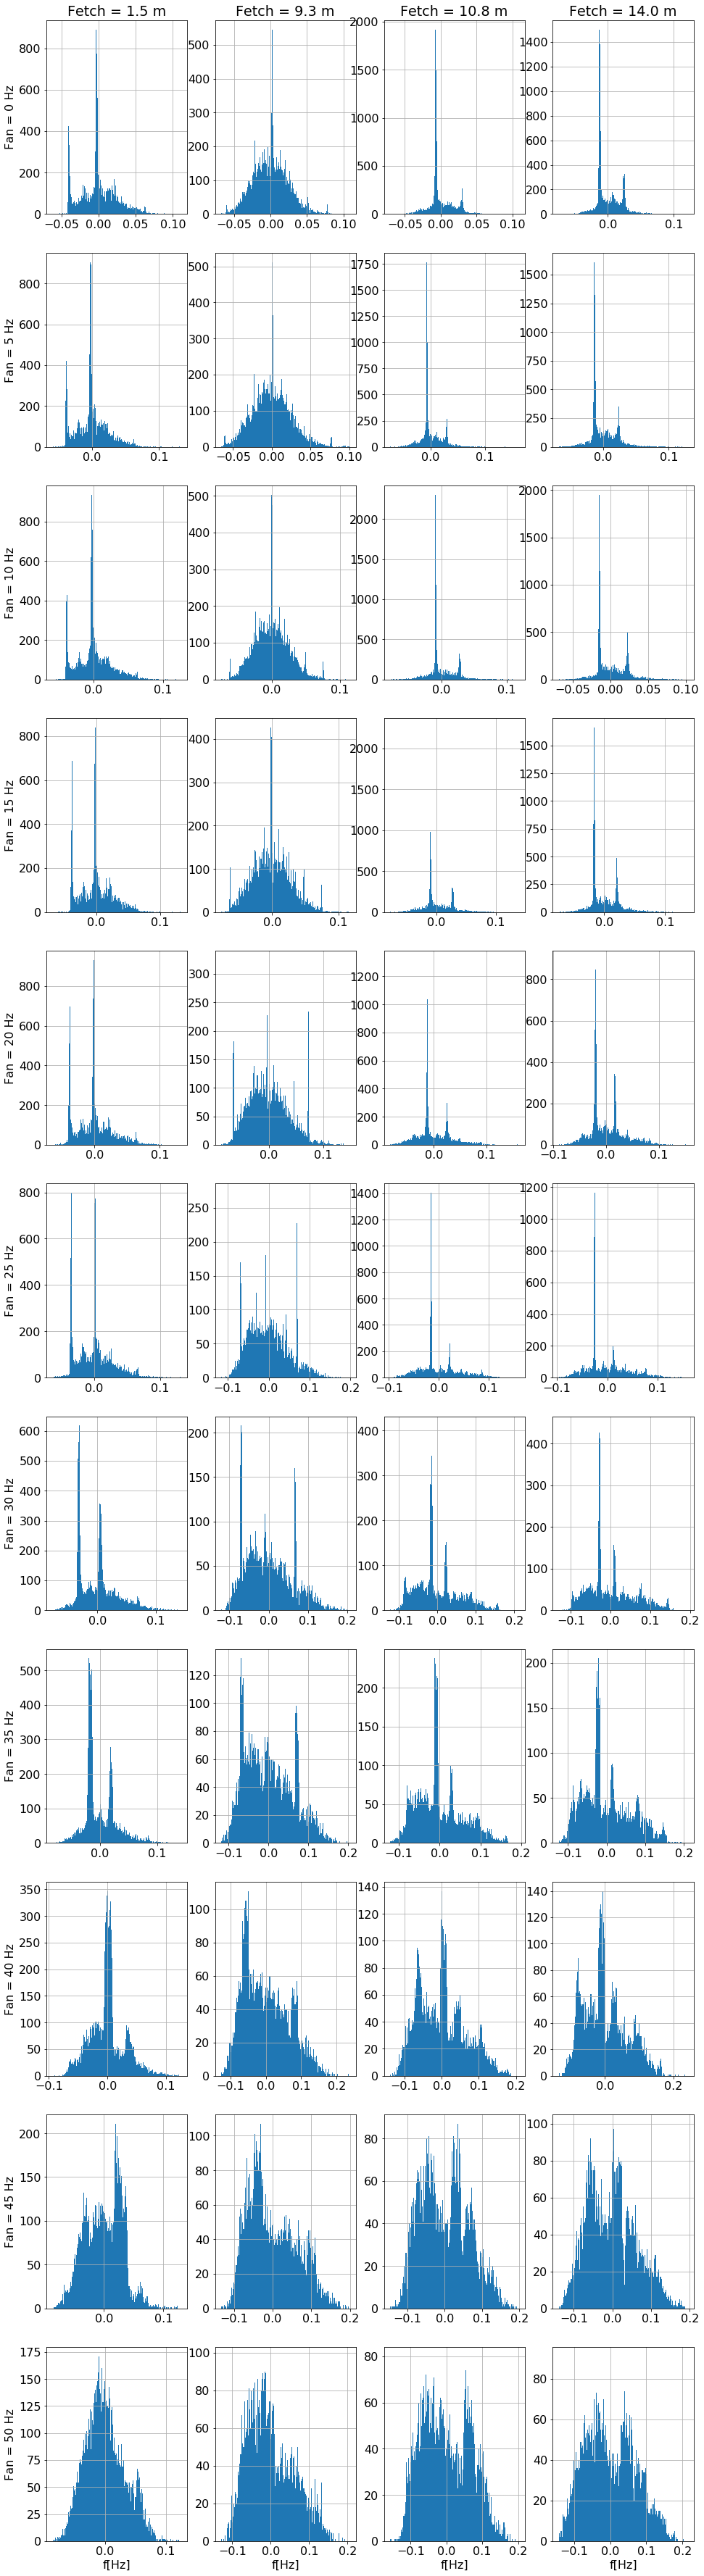

In [42]:
fig = plt.figure(figsize=(16, 64))
for n in range(num_runs):
    t0 = n * run_seconds + offset
    t1 = t0 + run_seconds - offset
    mask = (ds.time >= t0) & (ds.time <= t1)
    for i in range(num_wires):
        ax = plt.subplot2grid((num_runs, num_wires), (n, i))
        e = detrend(ds.eta_w[i,mask])
        plt.hist(e, np.arange(np.min(e), np.max(e), 1e-3))
        if n == 0: ax.set_title('Fetch = %.1f m' % ds.fetch_w[i])
        if i == 0: ax.set_ylabel('Fan = %i Hz' % fan[n])
        ax.grid()
        if n == num_runs - 1: ax.set_xlabel('f[Hz]')

In [43]:
GRAV = 9.8

def cp_cg(F, f, depth):
    """Return phase and group speeds for a wave spectrum."""
    w = 2 * np.pi * f
    k = w2k(w, depth)[0]
    cp = w[1:] / k[1:]
    cg = np.diff(w) / np.diff(k)
    return cp, cg

def radiation_stress(F, f, df, depth, rhow=1000):
    """Returns radiation stress."""
    cp, cg = cp_cg(F, f, depth)
    rad_stress_fac = 2 * cg / cp - 0.5
    return rhow * GRAV * np.sum(rad_stress_fac * F[1:] * df)

def stress_from_momentum_budget(H, dhdx, dSxxdx, dpdx, taub, rhow):
    """Returns the stress estimate from momentum budget components."""
    return rhow * GRAV * H * dhdx + H * dpdx + dSxxdx - taub

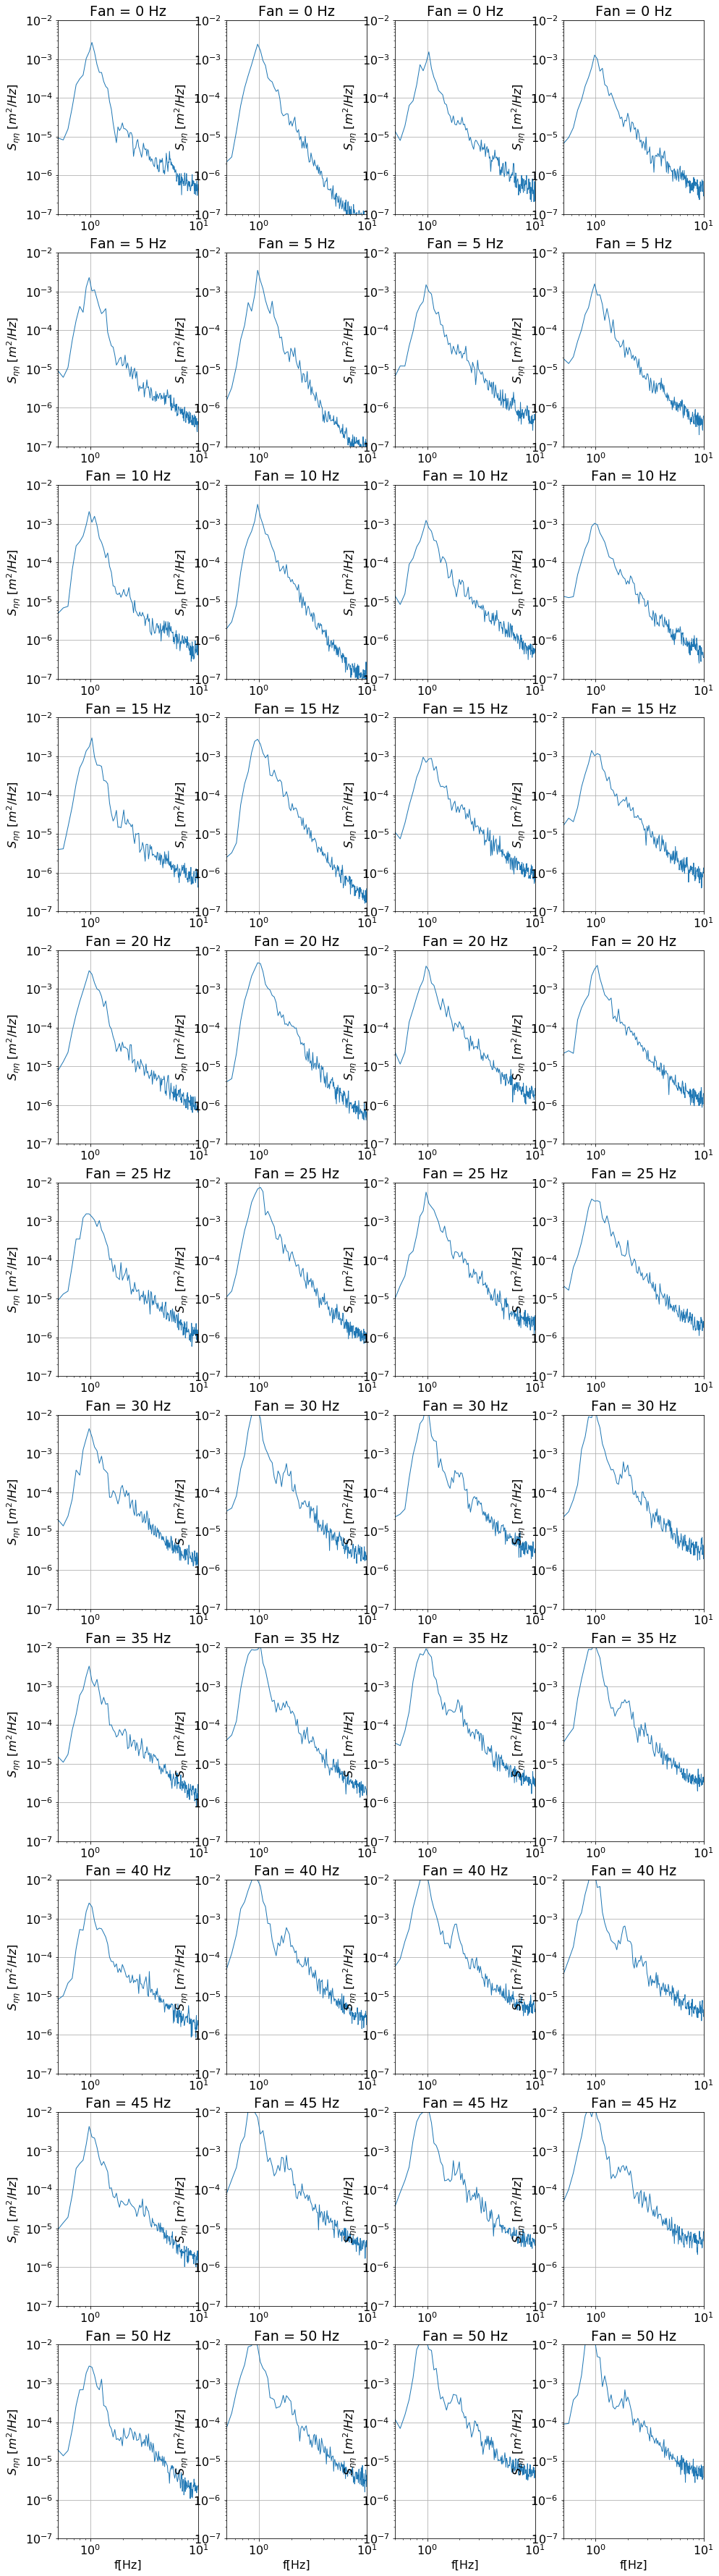

In [44]:
fig = plt.figure(figsize=(16, 64))
for n in range(num_runs):
    t0 = n * run_seconds + offset
    t1 = t0 + run_seconds - offset
    mask = (ds.time >= t0) & (ds.time <= t1)
    for i in range(num_wires):
        ax = plt.subplot2grid((num_runs, num_wires), (n, i))
        e = detrend(ds.eta_w[i,mask])
        F, f, df = power_spectrum(e, 1 / 20, binsize=32)
        ax.loglog(f, F, lw=1)
        ax.set_xlim(0.5, 1e1)
        ax.set_ylim(1e-7, 1e-2)
        ax.set_title('Fan = %i Hz' % fan[n])
        ax.set_ylabel('$S_{\eta\eta}$ [$m^2/Hz$]')
        ax.grid()
        if n == num_runs - 1: ax.set_xlabel('f[Hz]')

In [45]:
h = np.zeros((num_runs, 4))
Sxx = np.zeros((num_runs, 4))

for n in range(num_runs):
    t0 = n * run_seconds + offset
    t1 = t0 + run_seconds - offset
    mask = (ds.time >= t0) & (ds.time < t1)
    for i in range(4):
        h[n,i] = np.mean(ds.eta_w[i,mask])
        eta = detrend(ds.eta_w[i,mask])
        F, f, df = power_spectrum(eta, 1 / 20, binsize=1)
        fmask = (f > 0.5) & (f < 10)
        Sxx[n,i] = radiation_stress(F[fmask], f[fmask], np.diff(f)[0], 0.8, rhow=1000)

print(f)

[0.00000000e+00 1.85185185e-03 3.70370370e-03 ... 9.99444444e+00
 9.99629630e+00 9.99814815e+00]


[0.00000000e+00 1.85185185e-03 3.70370370e-03 ... 9.99444444e+00
 9.99629630e+00 9.99814815e+00]
50


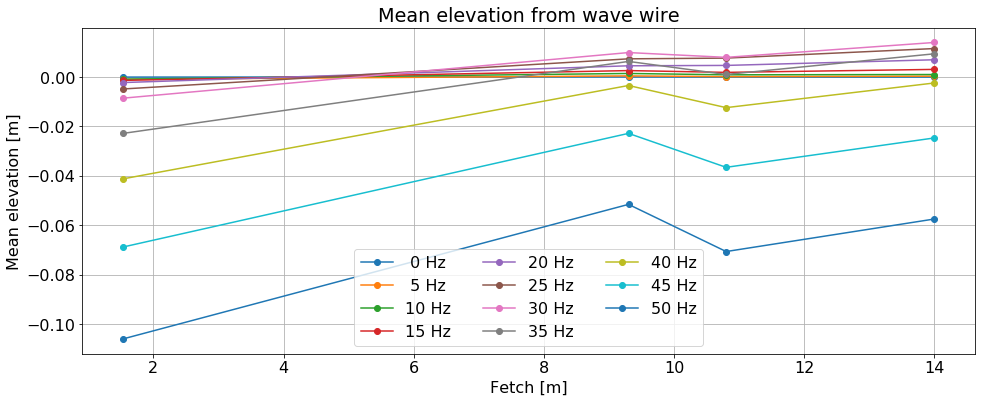

In [46]:
print(f)
plt.figure(figsize=(16, 6))
for n, f in enumerate(fan): #this is what makes the f variable from an array to a single value.
    plt.plot(ds.fetch_w, h[n,:], marker='o', label='%2i Hz' % f)
plt.legend(ncol=3)
plt.grid()
plt.xlabel('Fetch [m]')
plt.ylabel('Mean elevation [m]')
plt.title('Mean elevation from wave wire')

print(f)

Text(0.5, 1.0, 'Mean radiation stress from wave wire')

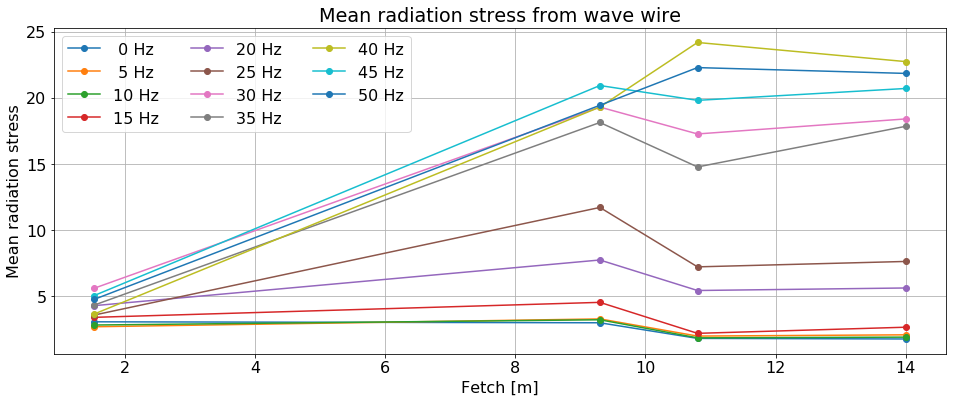

In [47]:
plt.figure(figsize=(16, 6))
for n, f in enumerate(fan):
    plt.plot(ds.fetch_w, Sxx[n,:], marker='o', label='%2i Hz' % f)
plt.legend(ncol=3)
plt.grid()
plt.xlabel('Fetch [m]')
plt.ylabel('Mean radiation stress')
plt.title('Mean radiation stress from wave wire')

In [48]:
good = [0, 1, 2, 3]
dhdx = np.zeros((num_runs))
dSxxdx = np.zeros((num_runs))
for n in range(num_runs):
    x = ds.fetch_w[good]
    dhdx[n] = np.polyfit(x, h[n,good], 1)[0]
    dSxxdx[n] = np.polyfit(x, Sxx[n,good], 1)[0]

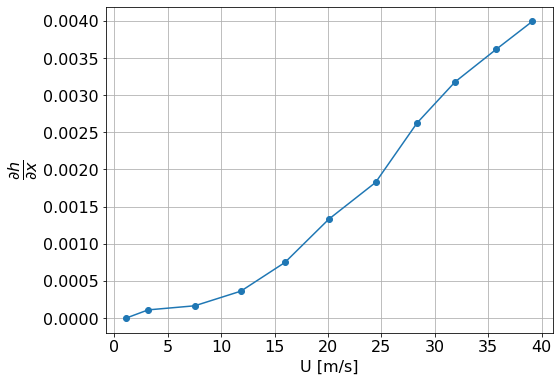

In [49]:
plt.figure(figsize=(8, 6))
plt.plot(U, dhdx, marker='o')
plt.xlabel('U [m/s]')
plt.ylabel(r'$\dfrac{\partial h}{\partial x}$')
plt.grid()

In [50]:
def disper(f,d,g):
    #based on w^2=gktanh(kd)
    w=2*np.pi*f
    import sympy as sp
    x=sp.symbols("x")
    k_all=np.zeros(np.size(w))
    for i in range(0,len(w)):
        i=int(i)
        k_all[i]=sp.nsolve(w[i]**2/g-x*sp.tanh(x*d),1,prec=50) #Numerical Approach on wave number
        i=i+1
        i=int(i)
    return k_all

In [74]:
mss_all = np.zeros((11, 4))

for n in range(num_runs):
    t0 = n * run_seconds + offset
    t1 = t0 + run_seconds - offset
    mask = (ds.time >= t0) & (ds.time < t1)
    for i in range(4):
        print('run',n,'fetch',i)

        h[n,i] = np.mean(ds.eta_w[i,mask])
        eta = detrend(ds.eta_w[i,mask])
        F, f, df = power_spectrum(eta, 1 / 20, binsize=1)
        fmask = (f > 0.5) & (f < 10)
        df = np.diff(f[1:])
        k_all=disper(f[1:],.8,9.81)
        dk = np.diff(k_all)
        Fk = F[2:] * df / dk
        mss = np.sum(Fk[:1001] * k_all[:1001]**2 * dk[:1001])
        print(k_all[1:],mss)
        mss_all[n-1,i]=mss
#possible errors: k, mss equation, 

run 0 fetch 0
[8.30691571e-03 1.24604882e-02 1.66141983e-02 ... 4.01983332e+02
 4.02132311e+02 4.02281318e+02] 0.014121662800534465
run 0 fetch 1
[8.30691571e-03 1.24604882e-02 1.66141983e-02 ... 4.01983332e+02
 4.02132311e+02 4.02281318e+02] 0.013962205907743719
run 0 fetch 2
[8.30691571e-03 1.24604882e-02 1.66141983e-02 ... 4.01983332e+02
 4.02132311e+02 4.02281318e+02] 0.00826936871333136
run 0 fetch 3
[8.30691571e-03 1.24604882e-02 1.66141983e-02 ... 4.01983332e+02
 4.02132311e+02 4.02281318e+02] 0.008441904364183517
run 1 fetch 0
[8.30691571e-03 1.24604882e-02 1.66141983e-02 ... 4.01983332e+02
 4.02132311e+02 4.02281318e+02] 0.01241758402040628
run 1 fetch 1
[8.30691571e-03 1.24604882e-02 1.66141983e-02 ... 4.01983332e+02
 4.02132311e+02 4.02281318e+02] 0.015758531239466213
run 1 fetch 2
[8.30691571e-03 1.24604882e-02 1.66141983e-02 ... 4.01983332e+02
 4.02132311e+02 4.02281318e+02] 0.009378519063647318
run 1 fetch 3
[8.30691571e-03 1.24604882e-02 1.66141983e-02 ... 4.01983332e+02

(0, 0.2)

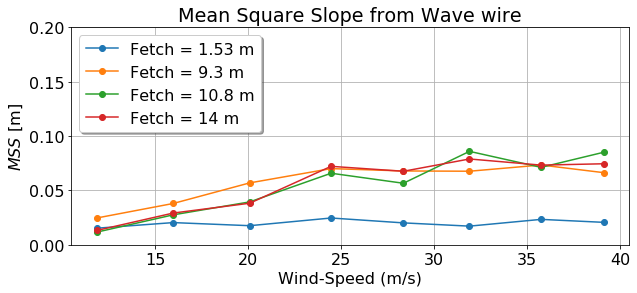

In [81]:
fig = plt.figure(figsize=(10, 4))
fetch_w=[1.53 , 9.3 , 10.8,14 ]
for i in range(4):
    plt.plot(U[3:], mss_all[2:-1,i], marker='o', label='Fetch = ' + str(fetch_w[i]) + ' m')
               
plt.legend(loc='upper left', fancybox=True, shadow=True)
plt.grid()
plt.title('Mean Square Slope from Wave wire')
plt.xlabel('Wind-Speed (m/s)')
plt.ylabel(r'$MSS$ [m]')
plt.ylim(0, 0.2)

